In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install keras-metrics

In [4]:
import os
import sys

import pandas as pd
import numpy as np

import keras
import random

from keras.models import Model
from keras.layers import Dense,LSTM,Activation,Dropout,Input,concatenate
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.utils import shuffle
from keras.utils.np_utils import to_categorical

import matplotlib
import matplotlib.pyplot as plt
import math

In [5]:
lookback = 8
grid_width = 5 # 栅格化粒度（每个小单元格的边长）
time_interval = 15 # 时间间隔

In [6]:
geohash_map = pd.read_csv(u'drive/MyDrive/Capstone/data/poi_data.csv')
geohash_vec = geohash_map[[ u'Amenity', u'Bump', u'Crossing', u'Entrance', u'Give_Way',
       u'Junction', u'Noexit', u'Railway', u'Roundabout', u'Station', u'Stop',
       u'Traffic_Calming', u'Traffic_Signal', u'Turning_Circle',
       u'Turning_Loop']]

geohash_dict={}
for index, row in geohash_map.iterrows():
    geohash_dict[row.Geohash] = np.array(geohash_vec.iloc[index])

geo_dict = dict(zip(geohash_map.Geohash.unique(), range(len(geohash_map.Geohash.unique()))))

In [7]:
df = pd.read_csv(u'drive/MyDrive/Capstone/data/integrated_data_{}_{}.csv'.format(str(grid_width),str(time_interval)))

df = df [[u'TimeStep', u'predicted_accident',u'Geohash',u'geohash_code', u'DOW_cat', u'DayLight',
    u'HOD_en0', u'HOD_en1', u'HOD_en2', u'HOD_en3', u'HOD_en4', u'T-Accident',
    u'T-Congestion', u'T-Incident', u'T-Restriction', u'T-Obstruction',
    u'T-Activity', u'T-Equipment', u'T-Other', u'W-Humidity',
    u'W-Precipitation', u'W-Pressure', u'W-Temperature', u'W-Visibility',
    u'W-WindSpeed', u'W-Rain', u'W-Snow', u'W-Fog', u'W-Hail']]

print ("zero accident =",float(df[df['T-Accident']==0].shape[0])/df.shape[0])

train = df[df.TimeStep <= df.TimeStep.max()*0.8]
test = df[df.TimeStep > df.TimeStep.max()*0.8]
sampling_rate = float(train[train['T-Accident']==0].shape[0])/train.shape[0]

random.seed(996)

for t in range(0,10):

  X_train = []
  y_train = []

  for idx, frame in train.groupby(train.Geohash):

    current_frame = frame.values
    geo_vec = geohash_dict[frame.Geohash.iloc[0]]
    geo_code = geo_dict[frame.Geohash.iloc[0]]

    for i in range(lookback, current_frame.shape[0]):
        if current_frame[i, 1] > 0 :
            a = np.concatenate((current_frame[i-lookback:i,4:].flatten(),geo_vec),axis=0)
            a = np.append(a, geo_code)
            X_train.append(a)
            y_train.append(1)
            
        elif random.uniform(0, 1) > sampling_rate:  # negative sampling for non-accident cases 
            a = np.concatenate((current_frame[i-lookback:i,4:].flatten(),geo_vec),axis=0)
            a = np.append(a, geo_code)
            X_train.append(a)
            y_train.append(0)  
  
  X_train = np.array(X_train)
  y_train = np.array(y_train)

  X_test = []
  y_test = []

  for idx, frame in test.groupby(test.Geohash):

    current_frame = frame.values
    geo_vec = geohash_dict[frame.Geohash.iloc[0]]
    geo_code = geo_dict[frame.Geohash.iloc[0]]

    for i in range(lookback, current_frame.shape[0]):
        if current_frame[i, 1] > 0 :
            a = np.concatenate((current_frame[i-lookback:i,4:].flatten(),geo_vec),axis=0)
            a = np.append(a, geo_code)
            X_test.append(a)
            y_test.append(1)
            
        elif random.uniform(0, 1) > sampling_rate:  # negative sampling for non-accident cases 
            a = np.concatenate((current_frame[i-lookback:i,4:].flatten(),geo_vec),axis=0)
            a = np.append(a, geo_code)
            X_test.append(a)
            y_test.append(0)  
  
  X_test = np.array(X_test)
  y_test = np.array(y_test)

  np.save(u'X_train_' + str(t) + '.npy',X_train) 
  np.save(u'y_train_' + str(t) + '.npy',y_train)
  np.save(u'X_test_' + str(t) + '.npy',X_test)
  np.save(u'y_test_' + str(t) + '.npy',y_test)

zero accident = 0.9963450432479988


In [51]:
# one-hot + lstm

from sklearn.preprocessing import OneHotEncoder

one_hot = OneHotEncoder(sparse=False)

num_set = 10 #测试的数据集数量

dropout = 0.2
batch_size=256

epoch=60

for unit_lstm in [32]:

  for unit_dense_before in [32]:

    for unit_dense_after in [64]:

      for num_lstm in [1]:

        for num_dense_after in [2]:

          accuracy_results = []

          for t in range(num_set):

            X_train = np.load('X_train_' + str(t) + '.npy', allow_pickle=True)
            y_train = np.load('y_train_' + str(t) + '.npy', allow_pickle=True)

            X_train,y_train = shuffle(X_train,y_train,random_state=996) 


            X_train_1 = X_train[:,:25*lookback].astype('float64') #时间相关特征
            X_train_2 = X_train[:,25*lookback:-1].astype('float64') #时间无关特征
            X_train_3 = X_train[:,-1].astype('float64')

            scaler_1 = MinMaxScaler()
            X_train_1 = scaler_1.fit_transform(X_train_1)

            scaler_2 = MinMaxScaler()
            X_train_2 = scaler_2.fit_transform(X_train_2)

            X_train_3 = one_hot.fit_transform(X_train_3.reshape(-1,1))

            X_train_1 = X_train_1.reshape((X_train_1.shape[0],lookback,int(X_train_1.shape[1]/lookback)))
            
            input_tr = Input(shape=(X_train_1.shape[1],X_train_1.shape[2])) #时间相关输入

            for i in range(0,num_lstm):
              if (num_lstm == 1):
                lstm = LSTM(units = unit_lstm, dropout=dropout, recurrent_dropout=dropout, return_sequences = False)(input_tr)
              elif (i == 0):
                lstm = LSTM(units = unit_lstm, dropout=dropout, recurrent_dropout=dropout, return_sequences = True)(input_tr)
              elif (i == num_lstm - 1):
                lstm = LSTM(units = unit_lstm, dropout=dropout, recurrent_dropout=dropout, return_sequences = False)(lstm)
              else:
                lstm = LSTM(units = unit_lstm, dropout=dropout, recurrent_dropout=dropout, return_sequences = True)(lstm)


            input_ti = Input(shape=(X_train_2.shape[1],))

            dense_before = Dense(unit_dense_before, activation='tanh')(input_ti)

            input_geo = Input(shape=(X_train_3.shape[1],))

            dense_after = concatenate([lstm,dense_before,input_geo])

            for i in range(0,num_dense_after):
              dense_after = Dense(unit_dense_after/pow(2,i),activation='relu')(dense_after)
              dense_after = Dropout(dropout)(dense_after)
            
            output = Dense(1,activation='sigmoid')(dense_after)
            model = Model(inputs= [input_tr,input_ti,input_geo], outputs=output)

            model.compile(optimizer='adam', loss='binary_crossentropy',metrics='binary_accuracy')

            earlystop = EarlyStopping(monitor='val_loss',mode='min',min_delta=0,patience=5,verbose=0)

            history = model.fit([X_train_1,X_train_2,X_train_3], y_train, batch_size=batch_size, epochs=epoch, verbose=0, validation_split=0.2, callbacks = [earlystop])

            # accuracy_results.append(history.history['val_binary_accuracy'][-1])

            X_test = np.load('X_test_' + str(t) + '.npy', allow_pickle=True)
            y_test = np.load('y_test_' + str(t) + '.npy', allow_pickle=True)

            X_test_1 = X_test[:,:200].astype('float64')
            X_test_2 = X_test[:,200:-1].astype('float64')
            X_test_3 = X_test[:,-1].astype('float64')

            X_test_1 = scaler_1.transform(X_test_1)
            X_test_2 = scaler_2.transform(X_test_2)

            X_test_1 = X_test_1.reshape((X_test_1.shape[0],lookback,int(X_test_1.shape[1]/lookback)))
            X_test_3 = one_hot.transform(X_test_3.reshape(-1,1))

            y_pred_prob = model.predict([X_test_1,X_test_2,X_test_3])
            y_pred = (y_pred_prob > 0.5)

            print(roc_auc_score(y_test, y_pred_prob))

0.9130502793015326
0.9122367205692951
0.9147507264535555
0.9166081456174568
0.9079375759413026
0.9084282993773048
0.9113956782029221
0.9048588782161627
0.9106959330494788
0.9047591624096922


In [52]:
results_0 = [0.9130502793015326,
0.9122367205692951,
0.9147507264535555,
0.9166081456174568,
0.9079375759413026,
0.9084282993773048,
0.9113956782029221,
0.9048588782161627,
0.9106959330494788,
0.9047591624096922]

In [53]:
np.mean(results_0)

0.9104721399138704

In [22]:
X_test = np.load('X_test_' + str(t) + '.npy', allow_pickle=True)
y_test = np.load('y_test_' + str(t) + '.npy', allow_pickle=True)

X_test_1 = X_test[:,:200].astype('float64')
X_test_2 = X_test[:,200:-1].astype('float64')
X_test_3 = X_test[:,-1].astype('float64')

X_test_1 = scaler_1.transform(X_test_1)
X_test_2 = scaler_2.transform(X_test_2)

X_test_1 = X_test_1.reshape((X_test_1.shape[0],lookback,int(X_test_1.shape[1]/lookback)))
X_test_3 = one_hot.transform(X_test_3.reshape(-1,1))

y_pred_prob = model.predict([X_test_1,X_test_2,X_test_3])
y_pred = (y_pred_prob > 0.5)
# print(classification_report(y_test, y_pred))
print(roc_auc_score(y_test, y_pred_prob))

              precision    recall  f1-score   support

           0       0.87      0.79      0.83       818
           1       0.84      0.90      0.87       973

    accuracy                           0.85      1791
   macro avg       0.85      0.85      0.85      1791
weighted avg       0.85      0.85      0.85      1791

0.9142149780001357


In [60]:
# no lstm

from sklearn.preprocessing import OneHotEncoder

num_set = 10 #测试的数据集数量
batch_size=256
epoch=60

for unit_lstm in [32]:

  for unit_dense_before in [32]:

    for unit_dense_after in [64]:

      for num_lstm in [1]:

        for num_dense_after in [2]:

          loss_results = []
          for t in range(num_set):

            X_train = np.load('X_train_' + str(t) + '.npy', allow_pickle=True)
            y_train = np.load('y_train_' + str(t) + '.npy', allow_pickle=True)

            X_train,y_train = shuffle(X_train,y_train,random_state=996) 


            X_train_1 = X_train[:,:25*lookback].astype('float64') #时间相关特征
            X_train_2 = X_train[:,25*lookback:-1].astype('float64') #时间无关特征
            X_train_3 = X_train[:,-1].astype('float64')

            scaler_1 = MinMaxScaler()
            X_train_1 = scaler_1.fit_transform(X_train_1)

            scaler_2 = MinMaxScaler()
            X_train_2 = scaler_2.fit_transform(X_train_2)

            X_train_3 = one_hot.fit_transform(X_train_3.reshape(-1,1))
            
            input_tr = Input(shape=(X_train_1.shape[1],)) #时间相关输入

            lstm = Dense(unit_lstm,activation='tanh')(input_tr)

            lstm = Dense(unit_lstm,activation='tanh')(lstm)

            input_ti = Input(shape=(X_train_2.shape[1],))

            dense_before = Dense(unit_dense_before, activation='tanh')(input_ti)

            input_geo = Input(shape=(X_train_3.shape[1],))

            dense_after = concatenate([lstm,dense_before,input_geo])

            for i in range(0,num_dense_after):
              dense_after = Dense(unit_dense_after/pow(2,i),activation='relu')(dense_after)
              dense_after = Dropout(dropout)(dense_after)
            
            output = Dense(1,activation='sigmoid')(dense_after)
            model = Model(inputs= [input_tr,input_ti,input_geo], outputs=output)

            model.compile(optimizer='adam', loss='binary_crossentropy',metrics='binary_accuracy')

            # model.summary()

            earlystop = EarlyStopping(monitor='val_loss',mode='min',min_delta=0,patience=5,verbose=0)

            history = model.fit([X_train_1,X_train_2,X_train_3], y_train, batch_size=batch_size, epochs=epoch, verbose=0, validation_split=0.2, callbacks = [earlystop])

            X_test = np.load('X_test_' + str(t) + '.npy', allow_pickle=True)
            y_test = np.load('y_test_' + str(t) + '.npy', allow_pickle=True)

            X_test_1 = X_test[:,:200].astype('float64')
            X_test_2 = X_test[:,200:-1].astype('float64')
            X_test_3 = X_test[:,-1].astype('float64')

            X_test_1 = scaler_1.transform(X_test_1)
            X_test_2 = scaler_2.transform(X_test_2)

            X_test_3 = one_hot.transform(X_test_3.reshape(-1,1))

            y_pred_prob = model.predict([X_test_1,X_test_2,X_test_3])
            y_pred = (y_pred_prob > 0.5)

            print(roc_auc_score(y_test, y_pred_prob))

0.910528650080285
0.9100992623622621
0.9167434407624725
0.9185226809645978
0.904867883699207
0.9089560284545474
0.9058657835636252
0.9035389382296035
0.9133950856807266
0.9056862884076976


In [67]:
results_1 = [
0.8959441597961588,
0.9050723977779802,
0.9023290189703672,
0.9033255760906058,
0.8938559327255564,
0.8973019063740604,
0.8976293513629161,
0.8917445947885874,
0.9032119785221385,
0.8941443607956703
]
np.mean(results_1)

0.8984559277204041

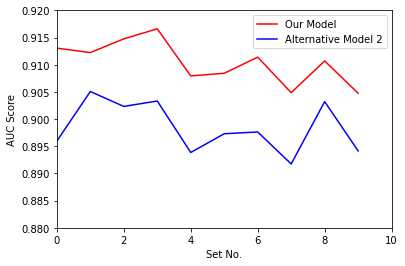

In [69]:
plt.plot(range(0,10), results_0, color='red', label='Our Model')
plt.plot(range(0,10), results_1, color='blue', label='Alternative Model 2')
plt.ylabel('AUC Score')
plt.xlabel('Set No.')
plt.xlim(0,10)
plt.ylim(0.88,0.92)
plt.legend()
plt.show()

In [31]:
X_test = np.load('X_test_' + str(t) + '.npy', allow_pickle=True)
y_test = np.load('y_test_' + str(t) + '.npy', allow_pickle=True)

X_test_1 = X_test[:,:200].astype('float64')
X_test_2 = X_test[:,200:-1].astype('float64')
X_test_3 = X_test[:,-1].astype('float64')

X_test_1 = scaler_1.transform(X_test_1)
X_test_2 = scaler_2.transform(X_test_2)

X_test_3 = one_hot.transform(X_test_3.reshape(-1,1))

y_pred_prob = model.predict([X_test_1,X_test_2,X_test_3])
y_pred = (y_pred_prob > 0.5)
print(classification_report(y_test, y_pred))
print(roc_auc_score(y_test, y_pred_prob))

              precision    recall  f1-score   support

           0       0.84      0.82      0.83       818
           1       0.85      0.87      0.86       973

    accuracy                           0.84      1791
   macro avg       0.84      0.84      0.84      1791
weighted avg       0.84      0.84      0.84      1791

0.909273489346839


In [66]:
# no one-hot

num_set = 10 #测试的数据集数量

dropout = 0.2

batch_size=256

epoch=60

for unit_lstm in [32]:

  for unit_dense_before in [32]:

    for unit_dense_after in [64]:

      for num_lstm in [1]:

        for num_dense_after in [2]:

          loss_results = []
          for t in range(num_set):

            X_train = np.load('X_train_' + str(t) + '.npy', allow_pickle=True)
            y_train = np.load('y_train_' + str(t) + '.npy', allow_pickle=True)

            X_train,y_train = shuffle(X_train,y_train,random_state=996) 

            X_train_1 = X_train[:,:25*lookback].astype('float64') #时间相关特征
            X_train_2 = X_train[:,25*lookback:-1].astype('float64') #时间无关特征

            scaler_1 = MinMaxScaler()
            X_train_1 = scaler_1.fit_transform(X_train_1)

            scaler_2 = MinMaxScaler()
            X_train_2 = scaler_2.fit_transform(X_train_2)

            X_train_1 = X_train_1.reshape((X_train_1.shape[0],lookback,int(X_train_1.shape[1]/lookback)))
            
            input_tr = Input(shape=(X_train_1.shape[1],X_train_1.shape[2])) #时间相关输入

            for i in range(0,num_lstm):
              if (num_lstm == 1):
                lstm = LSTM(units = unit_lstm, dropout=dropout, recurrent_dropout=dropout, return_sequences = False)(input_tr)
              elif (i == 0):
                lstm = LSTM(units = unit_lstm, dropout=dropout, recurrent_dropout=dropout, return_sequences = True)(input_tr)
              elif (i == num_lstm - 1):
                lstm = LSTM(units = unit_lstm, dropout=dropout, recurrent_dropout=dropout, return_sequences = False)(lstm)
              else:
                lstm = LSTM(units = unit_lstm, dropout=dropout, recurrent_dropout=dropout, return_sequences = True)(lstm)

            input_ti = Input(shape=(X_train_2.shape[1],))

            dense_before = Dense(unit_dense_before, activation='tanh')(input_ti)

            dense_after = concatenate([lstm,dense_before])

            for i in range(0,num_dense_after):
              dense_after = Dense(unit_dense_after/pow(2,i),activation='relu')(dense_after)
              dense_after = Dropout(dropout)(dense_after)
            
            output = Dense(1,activation='sigmoid')(dense_after)
            model = Model(inputs= [input_tr,input_ti], outputs=output)

            model.compile(optimizer='adam', loss='binary_crossentropy',metrics='binary_accuracy')

            earlystop = EarlyStopping(monitor='val_loss',mode='min',min_delta=0,patience=5,verbose=0)

            history = model.fit([X_train_1,X_train_2], y_train, batch_size=batch_size, epochs=epoch, verbose=0, validation_split=0.2, callbacks = [earlystop])

            X_test = np.load('X_test_' + str(t) + '.npy', allow_pickle=True)
            y_test = np.load('y_test_' + str(t) + '.npy', allow_pickle=True)

            X_test_1 = X_test[:,:200].astype('float64')
            X_test_2 = X_test[:,200:-1].astype('float64')

            X_test_1 = scaler_1.transform(X_test_1)
            X_test_2 = scaler_2.transform(X_test_2)

            X_test_1 = X_test_1.reshape((X_test_1.shape[0],lookback,int(X_test_1.shape[1]/lookback)))

            y_pred_prob = model.predict([X_test_1,X_test_2])
            y_pred = (y_pred_prob > 0.5)

            print(roc_auc_score(y_test, y_pred_prob))

0.8959441597961588
0.9050723977779802
0.9023290189703672
0.9033255760906058
0.8938559327255564
0.8973019063740604
0.8976293513629161
0.8917445947885874
0.9032119785221385
0.8941443607956703


In [20]:
X_test = np.load('X_test_' + str(t) + '.npy', allow_pickle=True)
y_test = np.load('y_test_' + str(t) + '.npy', allow_pickle=True)

X_test_1 = X_test[:,:200].astype('float64')
X_test_2 = X_test[:,200:-1].astype('float64')

X_test_1 = scaler_1.transform(X_test_1)
X_test_2 = scaler_2.transform(X_test_2)

X_test_1 = X_test_1.reshape((X_test_1.shape[0],lookback,int(X_test_1.shape[1]/lookback)))

y_pred_prob = model.predict([X_test_1,X_test_2])
y_pred = (y_pred_prob > 0.5)
print(classification_report(y_test, y_pred))
print(roc_auc_score(y_test, y_pred_prob))

              precision    recall  f1-score   support

           0       0.82      0.80      0.81       818
           1       0.84      0.85      0.84       973

    accuracy                           0.83      1791
   macro avg       0.83      0.82      0.82      1791
weighted avg       0.83      0.83      0.83      1791

0.8932114524936111


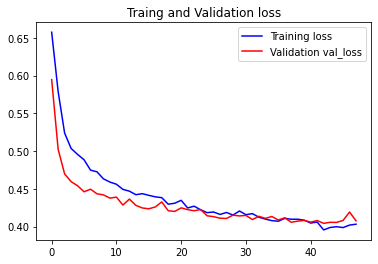

In [ ]:
epochs=range(len(history.history['loss']))

plt.figure()
plt.plot(epochs,history.history['loss'],'b',label='Training loss')
plt.plot(epochs,history.history['val_loss'],'r',label='Validation val_loss')
plt.title('Traing and Validation loss')
plt.legend()
plt.show()

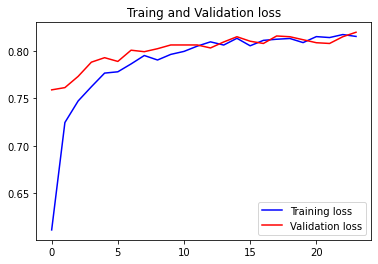

In [ ]:
epochs=range(len(history.history['loss']))

plt.figure()
plt.plot(epochs,history.history['binary_accuracy'],'b',label='Training loss')
plt.plot(epochs,history.history['val_binary_accuracy'],'r',label='Validation loss')
plt.title('Traing and Validation loss')
plt.legend()
plt.show()